In [1]:
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram
from math import pi, sqrt, sin, asin
import time

%matplotlib inline

In [2]:
def sprinkler(qc,q,a):
    qc.x(q[2])
    qc.x(a[0])
    qc.x(a[1])
    qc.x(a[2])
    qc.ccx(q[0],q[1],a[0])
    qc.ccx(q[1],q[2],a[1])
    qc.ccx(q[0],q[2],a[2])
    qc.mct([a[0],a[1],a[2],q[3]],a[3])
    qc.ccx(q[0],q[2],a[2])
    qc.ccx(q[1],q[2],a[1])
    qc.ccx(q[0],q[1],a[0])
    qc.x(a[2])
    qc.x(a[1])
    qc.x(a[0])
    qc.x(q[2])


In [14]:
def rotations():
    q=QuantumRegister(4)
    qc=QuantumCircuit(q)
    theta0=2.0*asin(sqrt(0.55))
    theta1=2.0*asin(sqrt(0.3))
    theta2=2.0*asin(sqrt(0.7))
    qc.ry(theta0,q[0])
    qc.ry(theta1,q[1])
    qc.ry(theta2,q[2])

    qc.h(q[3])
    return qc

rot=rotations().to_gate()
invrot=rot.inverse()

In [15]:
def grover():
    q=QuantumRegister(4)
    a=QuantumRegister(5)
    qc=QuantumCircuit(q,a)
    qc.x(a[3])
    qc.h(a[3])
    sprinkler(qc,q,a)
    qc.h(a[3])
    qc.x(a[3])
    qc.append(invrot,range(4))
    for i in range(q.size):
        qc.x(q[i])
    qc.mct([q[0],q[1],q[2],q[3]],a[4])
    qc.z(a[4])
    qc.mct([q[0],q[1],q[2],q[3]],a[4])
    for i in range(q.size):
        qc.x(q[i])
    qc.ry(2*pi,q[0]) 
    qc.append(rot,range(4))

    return qc

In [16]:
ggrover = grover().to_gate()
cggrover = ggrover.control()

In [17]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cu1(pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

qft_dagger = qft(t).to_gate().inverse()


In [18]:
t = 7   # no. of counting qubits
n = 4   # no. of searching qubits

q=QuantumRegister(n)
a=QuantumRegister(5)
s=QuantumRegister(t)
c=ClassicalRegister(t)

qc = QuantumCircuit(s,q,a,c) # Circuit with n+t qubits and t classical bits

for qubit in range(t):
    qc.h(qubit)

qc.append(rot, range(t,n+t))

# Begin controlled Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(cggrover, [qubit] + [*range(t, n+t+5)])
    iterations *= 2
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))



In [22]:
backend = Aer.get_backend('qasm_simulator')
start = time.time()

job_sim = execute(qc, backend, shots=1000)
end = time.time()
print(end - start)

result_sim = job_sim.result()


7.715755939483643


In [23]:
counts  = result_sim.get_counts()
weights={}
for  key, value in counts.items():
    theta=2*pi*int(key,2)/2**t
    newkey=round(2*sin(theta/2)**2,3)
    if newkey in weights:
        weights[newkey]=weights[newkey]+value
    else:
        weights[newkey]=value

In [24]:
weights

{0.0: 1,
 0.293: 1,
 0.366: 1,
 0.404: 1,
 0.444: 3,
 0.486: 6,
 0.529: 3,
 0.572: 14,
 0.617: 47,
 0.663: 655,
 0.71: 188,
 0.757: 28,
 0.805: 10,
 0.853: 7,
 0.902: 3,
 0.951: 3,
 1.049: 3,
 1.098: 2,
 1.29: 2,
 1.596: 1,
 1.707: 2,
 1.741: 1,
 1.773: 1,
 1.924: 1,
 0.019: 1,
 1.989: 1,
 1.981: 1,
 0.03: 2,
 1.337: 1,
 1.0: 4,
 0.058: 1,
 0.259: 2,
 0.043: 1,
 0.118: 1,
 0.169: 1}

In [31]:
qs={
    0.710: 171,
0.663: 692,
0.757: 29,
0.617: 39,
0.529: 7,
0.486: 6,
0.805: 11,
0.572: 17,
1.000: 2,
0.019: 1,
1.049: 2,
1.904: 1,
1.428: 1,
0.404: 2,
0.293: 1,
0.902: 4,
1.290: 2,
0.169: 1,
0.197: 2,
0.444: 2,
0.259: 1,
0.118: 1,
1.098: 1,
0.227: 1,
1.634: 1,
0.366: 1,
0.951: 1,
}

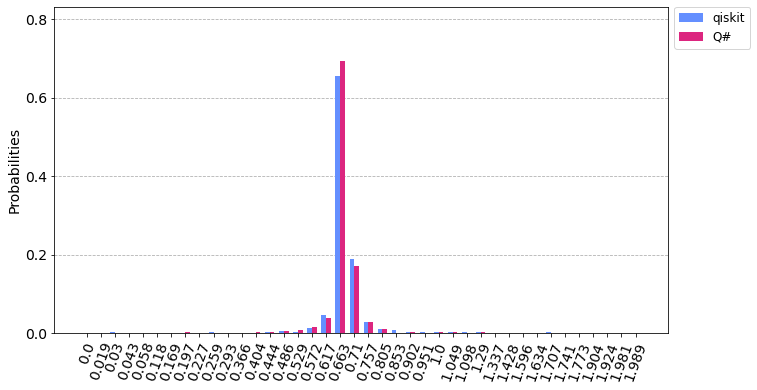

In [35]:
fig=plot_histogram([weights,qs],sort='asc',bar_labels=False, legend=['qiskit','Q#'],figsize =(11,6))
fig

In [36]:
fig.savefig("qwmc.pdf", bbox_inches='tight')